In [29]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [30]:
import logging

import holoviews as hv
import hvplot.polars  # noqa
import neurokit2 as nk
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.data.quality_checks import check_sample_rate
from src.features.scaling import scale_min_max
from src.features.transforming import merge_dfs
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG, ignore_libs=("Comm", "bokeh", "tornado", "matplotlib")
)
logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [31]:
db = DatabaseManager()

In [32]:
with db:
    eda = db.get_table("Feature_EDA")
eda

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_raw,eda_tonic,eda_phasic
u16,u8,u8,u32,f64,i64,f64,f64,f64
23,1,3,23654,184809.3687,204865,3.855469,4.417003,-0.561535
23,1,3,23667,184921.813,204878,3.877723,4.436572,-0.55885
23,1,3,23682,185020.5501,204893,3.899728,4.456094,-0.556366
23,1,3,23695,185125.2694,204906,3.919598,4.475845,-0.556248
23,1,3,23709,185247.5105,204920,3.950526,4.49607,-0.545544
23,1,3,23722,185358.8572,204933,3.991767,4.516189,-0.524422
…,…,…,…,…,…,…,…,…
513,12,50,345041,2.6956e6,473254,26.691045,26.71623,0.00537
513,12,50,345053,2.6957e6,473266,26.683349,26.716216,-0.001579


In [33]:
scale_min_max(eda).hvplot(
    x="timestamp",
    y=["eda_raw", "eda_phasic", "eda_tonic"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3368bb7c-7115-4af9-9d2a-b29900eb5647': {'version…

In [34]:
check_sample_rate(eda)

13:08:37 | DEBUG   | quality_checks | Sample rate per trial: [ 9.91  9.9   9.9   9.9   9.93  9.87  9.91  9.89  9.93  9.89  9.9   9.91
  9.91  9.9   9.92  9.91  9.93  9.87  9.89  9.91  9.87  9.87  9.87  9.9
  9.9   9.9   9.89  9.89  9.89  9.92  9.92  9.89  9.9   9.89  9.91  9.9
  9.88  9.88  9.88  9.87  9.9   9.88  9.9   9.88  9.89  9.88  9.86  9.89
  9.89  9.88  9.88  9.87 10.06 10.06 10.06 10.07 10.07 10.07 10.06 10.07
 10.06 10.07 10.07  9.87  9.9   9.86  9.89  9.88  9.88  9.87  9.89  9.87
  9.89  9.86  9.86  9.9   9.89  9.9   9.9   9.91  9.9   9.9   9.9   9.89
  9.88  9.89  9.87  9.89  9.85  9.88  9.9   9.88  9.9   9.87  9.88  9.9
  9.88  9.86  9.88 10.09 10.06 10.06 10.05 10.06 10.06 10.08 10.05 10.05
 10.06 10.07 10.06  9.88  9.87  9.89  9.88  9.88  9.88  9.91  9.88  9.86
  9.86  9.89  9.89  9.9   9.89  9.89  9.9   9.91  9.88  9.88  9.92  9.89
  9.89  9.88  9.9  10.07 10.08 10.06 10.06 10.07 10.06 10.07 10.06 10.07
 10.06 10.07 10.06  9.89  9.91  9.91  9.9   9.91  9.91  9.89  9.89

## Detrended tonic component

In [35]:
from src.features.eda import detrend_tonic_component

eda = detrend_tonic_component(eda)
eda

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended
u16,u8,u8,u32,f64,i64,f64,f64,f64,f64
23,1,3,23654,184809.3687,204865,3.855469,4.417003,-0.561535,-2.373273
23,1,3,23667,184921.813,204878,3.877723,4.436572,-0.55885,-2.353704
23,1,3,23682,185020.5501,204893,3.899728,4.456094,-0.556366,-2.334181
23,1,3,23695,185125.2694,204906,3.919598,4.475845,-0.556248,-2.314429
23,1,3,23709,185247.5105,204920,3.950526,4.49607,-0.545544,-2.294204
23,1,3,23722,185358.8572,204933,3.991767,4.516189,-0.524422,-2.274084
…,…,…,…,…,…,…,…,…,…
513,12,50,345041,2.6956e6,473254,26.691045,26.71623,0.00537,-0.071625
513,12,50,345053,2.6957e6,473266,26.683349,26.716216,-0.001579,-0.070656


In [36]:
scale_min_max(eda).hvplot(
    x="timestamp",
    y=["eda_raw", "eda_phasic", "eda_tonic", "eda_tonic_detrended"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'dec372c2-d9c5-4c83-9190-b09117bf05f4': {'version…

## With Stimulus data

In [37]:
with db:
    stimulus = db.get_table("Feature_stimulus")

merged = merge_dfs([eda, stimulus])
scale_min_max(merged.interpolate()).hvplot(
    x="timestamp",
    y=[
        "eda_tonic",
        "eda_tonic_detrended",
        # "rating",
        "eda_raw",
    ],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'56a6531c-ec26-4e57-87cc-75cb16ba5a57': {'version…

## Misc

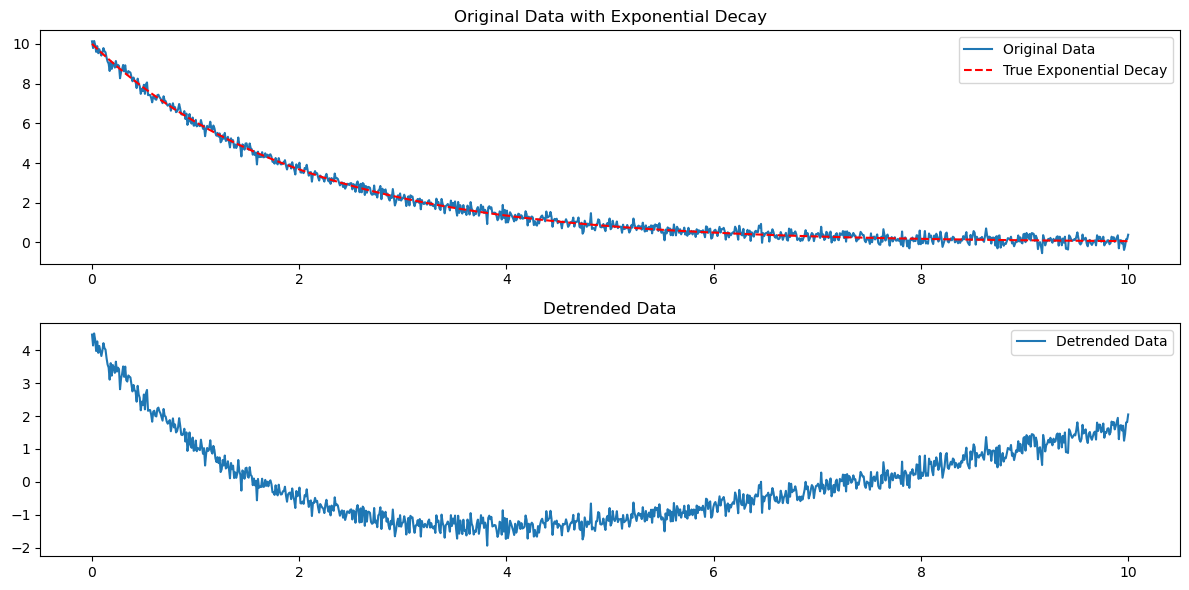

Mean of detrended data: 0.000000
Mean of original data: 1.998805


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


# Generate sample data
def generate_exponential_decay(t, amplitude, decay_rate, noise_level):
    decay = amplitude * np.exp(-decay_rate * t)
    noise = np.random.normal(0, noise_level, len(t))
    return decay + noise


# Set up parameters
t = np.linspace(0, 10, 1000)
amplitude = 10
decay_rate = 0.5
noise_level = 0.2

# Generate synthetic data
data = generate_exponential_decay(t, amplitude, decay_rate, noise_level)

# Detrend the data
detrended_data = signal.detrend(data)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, data, label="Original Data")
plt.plot(t, amplitude * np.exp(-decay_rate * t), "r--", label="True Exponential Decay")
plt.title("Original Data with Exponential Decay")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, detrended_data, label="Detrended Data")
plt.title("Detrended Data")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print the mean of the detrended data
print(f"Mean of detrended data: {np.mean(detrended_data):.6f}")
print(f"Mean of original data: {np.mean(data):.6f}")
